In [1]:
import pandas as pd
df = pd.read_csv('train_test_topic_model.csv')
df.head()
df = pd.DataFrame(df)
df.dtypes

Year           int64
Month          int64
M_Y           object
Category      object
Type          object
Area          object
Detail        object
Date          object
Time Lost    float64
cause         object
dtype: object

In [2]:
df.cause.unique()
df.isnull().sum()
df = df.dropna()
df.shape
df.drop_duplicates(inplace=True)
df.shape
df["cause"] = df["cause"].str.lower()
df["Detail"] = df["Detail"].str.lower()

In [3]:
df['cause'] = df['cause'].replace(to_replace =['electrode','pcb'], 
                            value ='electric tray',regex=True)
df['cause'] = df['cause'].replace(to_replace =['regulator','pilot'], 
                            value ='gas tray',regex=True)
df['cause'] = df['cause'].replace(to_replace =['hx tube'], 
                            value ='heat exchange/hx tube',regex=True)
df['cause'] = df['cause'].replace(to_replace =['prepare'], 
                            value ='arrangement',regex=True)
df['cause'] = df['cause'].str.strip()
df['Detail'] = df['Detail'].replace(to_replace =['offline downtime:','online downtime;','online downtime:','offline downtime'], 
                            value ='',regex=True)


In [5]:
df = df[df.cause != 'valve']

In [6]:
df.head(5)

,Year,Month,M_Y,Category,Type,Area,Detail,Date,Time Lost,cause
0,2017,1,Jan-17,Quality,External,Other,1 x pcb (dx) boot loader could not be found.,11-Jan-17,0.25,programming
1,2017,1,Jan-17,Quality,Internal,Assembly,1 x dx1500 hx nut loose on manifold - reowrked,11-Jan-17,0.50,pemserts
2,2017,1,Jan-17,Quality,Internal,NC Cell,1 x fs730 rh side folded incorrectly - replaced.,17-Jan-17,0.75,others
3,2017,1,Jan-17,Quality,Internal,NC Cell,1 x dx glass insert came loose - reworked,17-Jan-17,0.50,electric tray
4,2017,1,Jan-17,Quality,Internal,Assembly,1 x af spark electrode cracked ceramic causin...,17-Jan-17,0.50,electric tray


In [7]:
len(df.cause.value_counts())

40

In [8]:
df.cause.unique()

array(['programming', 'pemserts', 'others', 'electric tray', 'welding',
       'wiring', 'pressure switch', 'folding', 'gas tray', 'firebox',
       'chassis', 'burnner', 'fastener', 'normal', 'remote', 'e7',
       'painting/powder coating', 'arrangement', 'laser', 'glass', 'fan',
       'modulating valve', 'heat exchange/hx tube', 'tco bracket', 'e3',
       'testing equitment /method', 'e4', 'teddington valve',
       'maxitrol valves', 'material', 'resistors', 'tape', 'tco', 'e2',
       'kupo', 'stone guards', 'bromic hose/bracket',
       'heat exchange/heat exchange/hx tube', 'wait', 'serial numbers'],
      dtype=object)

In [9]:
df['cause'] = df['cause'].replace(to_replace =['heat exchange/heat exchange/hx tube'], 
                            value ='heat exchange/hx tube',regex=True)

In [10]:
df.cause.unique()

array(['programming', 'pemserts', 'others', 'electric tray', 'welding',
       'wiring', 'pressure switch', 'folding', 'gas tray', 'firebox',
       'chassis', 'burnner', 'fastener', 'normal', 'remote', 'e7',
       'painting/powder coating', 'arrangement', 'laser', 'glass', 'fan',
       'modulating valve', 'heat exchange/hx tube', 'tco bracket', 'e3',
       'testing equitment /method', 'e4', 'teddington valve',
       'maxitrol valves', 'material', 'resistors', 'tape', 'tco', 'e2',
       'kupo', 'stone guards', 'bromic hose/bracket', 'wait',
       'serial numbers'], dtype=object)

In [16]:
from io import StringIO
col = ['cause', 'Detail']
df = df[col]
df = df[pd.notnull(df['Detail'])]
df.columns = ['cause', 'Detail']
df['category_id'] = df['cause'].factorize()[0]
category_id_df = df[['cause', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'cause']].values)
df.head()

,cause,Detail,category_id
0,programming,1 x pcb (dx) boot loader could not be found.,0
1,pemserts,1 x dx1500 hx nut loose on manifold - reowrked,1
2,others,1 x fs730 rh side folded incorrectly - replaced.,2
3,electric tray,1 x dx glass insert came loose - reworked,3
4,electric tray,1 x af spark electrode cracked ceramic causin...,3


In [17]:
#! pip install matplotlib

### Imbalanced Classes

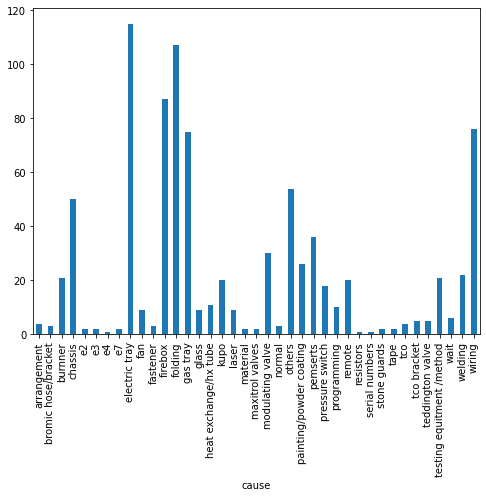

In [18]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df.groupby('cause').Detail.count().plot.bar(ylim=0)
plt.show()

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(df.Detail).toarray()
labels = df.category_id
features.shape

(876, 304)

In [20]:
from sklearn.feature_selection import chi2
import numpy as np
N = 2
for cause, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(cause))
  print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

# 'arrangement':
  . Most correlated unigrams:
. parts
. revision
  . Most correlated bigrams:
. folded wrong
. folded incorrectly
# 'bromic hose/bracket':
  . Most correlated unigrams:
. issue
. hose
  . Most correlated bigrams:
. folded incorrectly
. flexi hose
# 'burnner':
  . Most correlated unigrams:
. burner
. burners
  . Most correlated bigrams:
. folded incorrectly
. df burner
# 'chassis':
  . Most correlated unigrams:
. panels
. drilling
  . Most correlated bigrams:
. dl850 chassis
. chassis bases
# 'e2':
  . Most correlated unigrams:
. burn
. e2
  . Most correlated bigrams:
. folded incorrectly
. e2 error
# 'e3':
  . Most correlated unigrams:
. end
. e3
  . Most correlated bigrams:
. folded wrong
. folded incorrectly
# 'e4':
  . Most correlated unigrams:
. e4
. error
  . Most correlated bigrams:
. folded incorrectly
. e4 error
# 'e7':
  . Most correlated unigrams:
. issues
. e7
  . Most correlated bigrams:
. folded incorrectly
. issues ds1400
# 'electric tray':
  . Most corre

c:\users\kate.liu\appdata\local\programs\python\python38\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
c:\users\kate.liu\appdata\local\programs\python\python38\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
c:\users\kate.liu\appdata\local\programs\python\python38\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
c:\users\kate.liu\appdata\local\programs\py

### Multi-Class Classifier: Features and Design

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

X_train, X_test, y_train, y_test = train_test_split(df['Detail'], df['cause'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = MultinomialNB().fit(X_train_tfidf, y_train)


#### Logistic Regression
#### (Multinomial) Naive Bayes
#### Linear Support Vector Machine
#### Random Forest

In [22]:
# !pip install seaborn

In [ ]:
from sklearn.naive_bayes import GaussianNB,BernoulliNB,MultinomialNB,ComplementNB
from skearn.pipeline import Pipeline

c:\users\kate.liu\appdata\local\programs\python\python38\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
c:\users\kate.liu\appdata\local\programs\python\python38\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
c:\users\kate.liu\appdata\local\programs\python\python38\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
c:\users\kate.liu\appdata\local\programs\python\python38\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


[('RandomForestClassifier', 0, 0.3977272727272727), ('RandomForestClassifier', 1, 0.32954545454545453), ('RandomForestClassifier', 2, 0.3522727272727273), ('RandomForestClassifier', 3, 0.4090909090909091), ('RandomForestClassifier', 4, 0.42045454545454547), ('RandomForestClassifier', 5, 0.4772727272727273), ('RandomForestClassifier', 6, 0.47126436781609193), ('RandomForestClassifier', 7, 0.40229885057471265), ('RandomForestClassifier', 8, 0.39080459770114945), ('RandomForestClassifier', 9, 0.3793103448275862), ('LinearSVC', 0, 0.6818181818181818), ('LinearSVC', 1, 0.7045454545454546), ('LinearSVC', 2, 0.7159090909090909), ('LinearSVC', 3, 0.7727272727272727), ('LinearSVC', 4, 0.6818181818181818), ('LinearSVC', 5, 0.75), ('LinearSVC', 6, 0.7931034482758621), ('LinearSVC', 7, 0.7816091954022989), ('LinearSVC', 8, 0.6091954022988506), ('LinearSVC', 9, 0.6781609195402298), ('MultinomialNB', 0, 0.5681818181818182), ('MultinomialNB', 1, 0.5227272727272727), ('MultinomialNB', 2, 0.55681818181

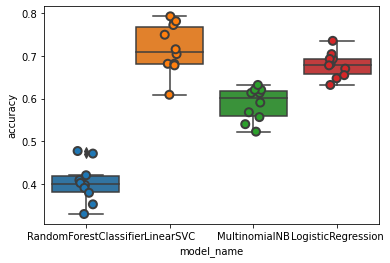

In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 10
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
print(entries)
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

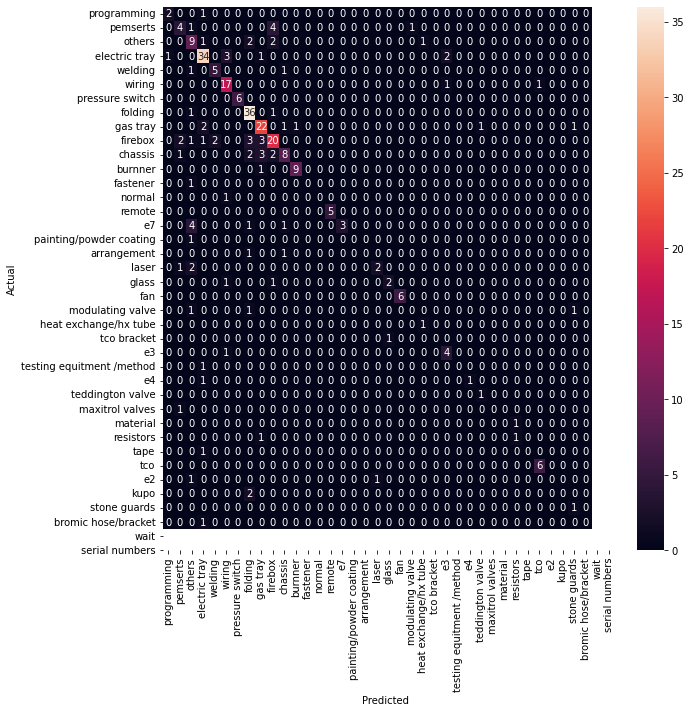

In [29]:
model = LinearSVC()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.cause.values, yticklabels=category_id_df.cause.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [27]:
from IPython.display import display
for predicted in category_id_df.category_id:
  for actual in category_id_df.category_id:
    if predicted != actual and conf_mat[actual, predicted] >= -100:
      print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], id_to_category[predicted], conf_mat[actual, predicted]))
      display(df.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['cause', 'Detail']])
      print('')

'pemserts' predicted as 'programming' : 0 examples.


,cause,Detail



'others' predicted as 'programming' : 0 examples.


,cause,Detail



'electric tray' predicted as 'programming' : 1 examples.


,cause,Detail
255,electric tray,df electronics trays not ready.



'welding' predicted as 'programming' : 0 examples.


,cause,Detail



'wiring' predicted as 'programming' : 0 examples.


,cause,Detail



'pressure switch' predicted as 'programming' : 0 examples.


,cause,Detail



'folding' predicted as 'programming' : 0 examples.


,cause,Detail



'gas tray' predicted as 'programming' : 0 examples.


,cause,Detail



'firebox' predicted as 'programming' : 0 examples.


,cause,Detail



'chassis' predicted as 'programming' : 0 examples.


,cause,Detail



'burnner' predicted as 'programming' : 0 examples.


,cause,Detail



'fastener' predicted as 'programming' : 0 examples.


,cause,Detail



'normal' predicted as 'programming' : 0 examples.


,cause,Detail



'remote' predicted as 'programming' : 0 examples.


,cause,Detail



'e7' predicted as 'programming' : 0 examples.


,cause,Detail



'painting/powder coating' predicted as 'programming' : 0 examples.


,cause,Detail



'arrangement' predicted as 'programming' : 0 examples.


,cause,Detail



'laser' predicted as 'programming' : 0 examples.


,cause,Detail



'glass' predicted as 'programming' : 0 examples.


,cause,Detail



'fan' predicted as 'programming' : 0 examples.


,cause,Detail



'modulating valve' predicted as 'programming' : 0 examples.


,cause,Detail



'heat exchange/hx tube' predicted as 'programming' : 0 examples.


,cause,Detail



'tco bracket' predicted as 'programming' : 0 examples.


,cause,Detail



'e3' predicted as 'programming' : 0 examples.


,cause,Detail



'testing equitment /method' predicted as 'programming' : 0 examples.


,cause,Detail



'e4' predicted as 'programming' : 0 examples.


,cause,Detail



'teddington valve' predicted as 'programming' : 0 examples.


,cause,Detail



'maxitrol valves' predicted as 'programming' : 0 examples.


,cause,Detail



'material' predicted as 'programming' : 0 examples.


,cause,Detail



'resistors' predicted as 'programming' : 0 examples.


,cause,Detail



'tape' predicted as 'programming' : 0 examples.


,cause,Detail



'tco' predicted as 'programming' : 0 examples.


,cause,Detail



'e2' predicted as 'programming' : 0 examples.


,cause,Detail



'kupo' predicted as 'programming' : 0 examples.


,cause,Detail



'stone guards' predicted as 'programming' : 0 examples.


,cause,Detail



'bromic hose/bracket' predicted as 'programming' : 0 examples.


,cause,Detail


IndexError: index 37 is out of bounds for axis 0 with size 37